# Testing High-Dimensional Benchmarks - MM and MM-2 Solver
DenseICNN-based benchmark training.
**GPU-only implementation.**

In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import gc

from sklearn.decomposition import PCA

from src import distributions
from src import map_benchmark

from src.icnn import DenseICNN
from src.tools import train_identity_map, unfreeze, freeze
from src.plotters import plot_benchmark_emb, plot_W2, plot_benchmark_metrics
import src.map_benchmark as mbm
from src.metrics import score_fitted_maps, score_baseline_maps, metrics_to_dict

import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

## Changable Config

In [2]:
DIM = 16
BATCH_SIZE = 1024

REVERSED = False
CONVEX = False # False = MM solver, True = MMv2 solver

GPU_DEVICE = 1

## Hardcoded config

In [4]:
BENCHMARK = 'Mix3toMix10'

MAX_ITER = 50001
LR = 1e-3
INNER_ITERS = 15

D_HYPERPARAMS = {
    'dim' : DIM,
    'rank' : 1,
    'hidden_layer_sizes' : [max(2*DIM, 64), max(2*DIM, 64), max(DIM, 32)],
    'strong_convexity' : 1e-4
}

OUTPUT_PATH = '../logs/' + BENCHMARK
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

if CONVEX:
    METHOD = 'MMv2' if not REVERSED else 'MMv2:R'
else:
    METHOD = 'MM' if not REVERSED else 'MM:R'

assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)
torch.manual_seed(0x000000); np.random.seed(0x000000)

## Benchmark Setup

In [5]:
benchmark = mbm.Mix3ToMix10Benchmark(DIM)
emb_X = PCA(n_components=2).fit(benchmark.input_sampler.sample(2**14).cpu().detach().numpy())
emb_Y = PCA(n_components=2).fit(benchmark.output_sampler.sample(2**14).cpu().detach().numpy())

## Potentials Setup

In [6]:
D = DenseICNN(**D_HYPERPARAMS).cuda()
D_conj = DenseICNN(**D_HYPERPARAMS).cuda()

pretrain_sampler = distributions.StandardNormalSampler(dim=DIM)
print('Pretraining identity potential. Final MSE:', train_identity_map(D, pretrain_sampler, convex=CONVEX, blow=3))
D_conj.load_state_dict(D.state_dict())
del pretrain_sampler

Pretraining identity potential. Final MSE: 0.0009637885959818959


## Main training

In [7]:
D_opt = torch.optim.Adam(D.parameters(), lr=LR)
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=LR)

In [8]:
W2_history = []
metrics = dict(L2_UVP_fwd=[], cos_fwd=[], L2_UVP_inv=[], cos_inv=[])
baselines = {
    baseline : metrics_to_dict(*score_baseline_maps(benchmark, baseline))
    for baseline in ['identity', 'constant', 'linear']
}
L2_UVP_fwd_min, L2_UVP_inv_min = np.inf, np.inf

Iteration 50000


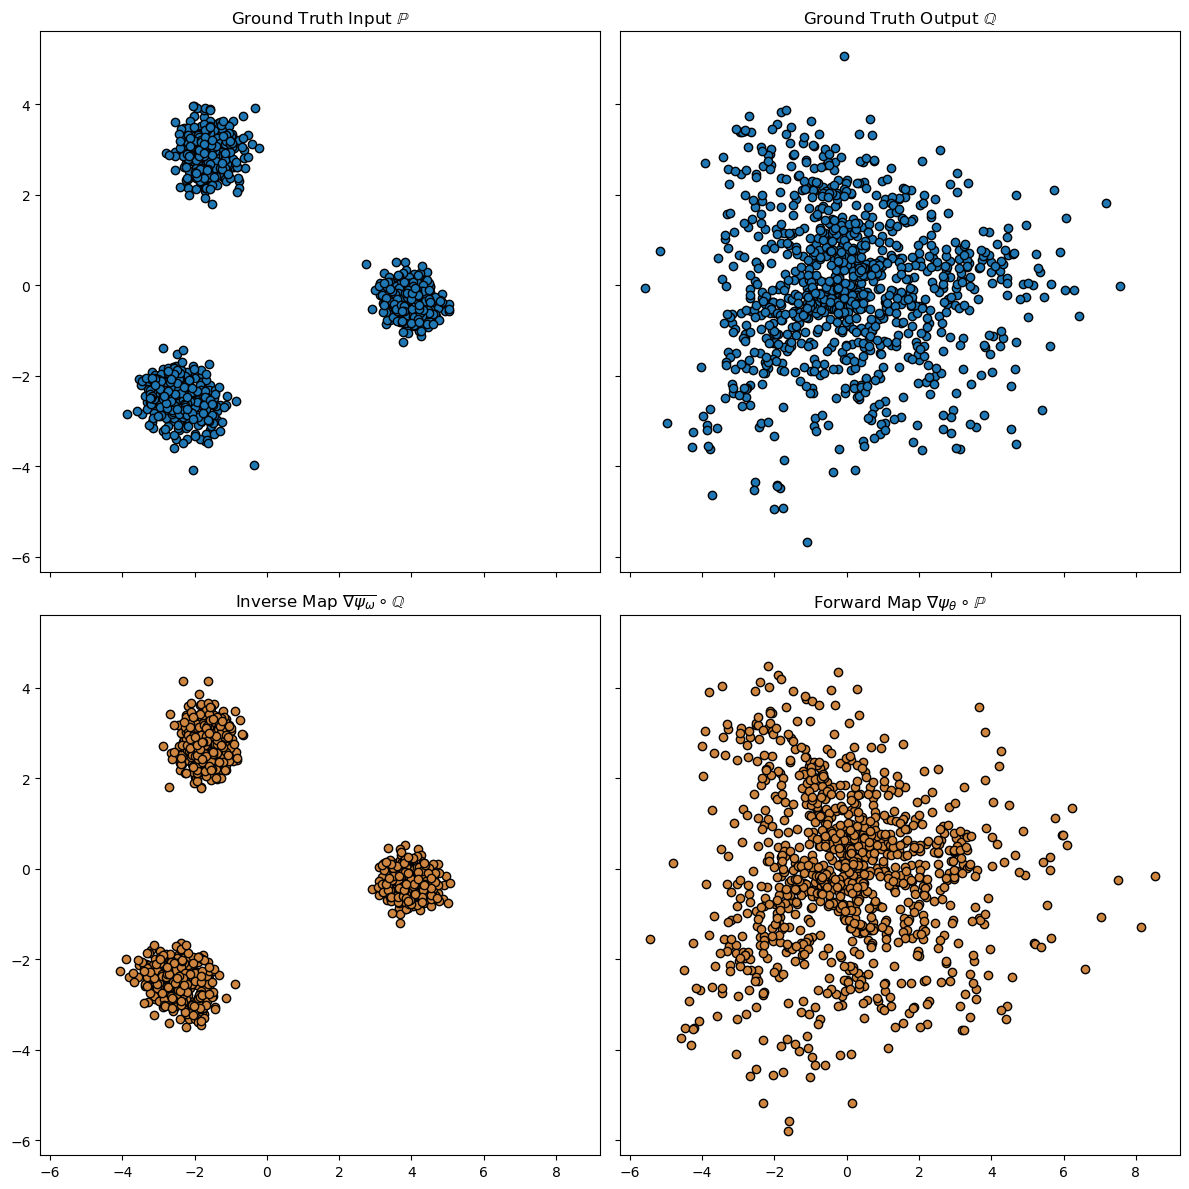

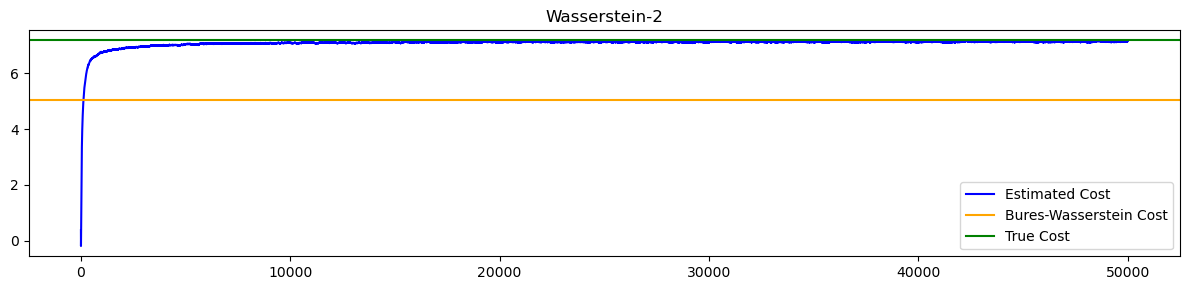

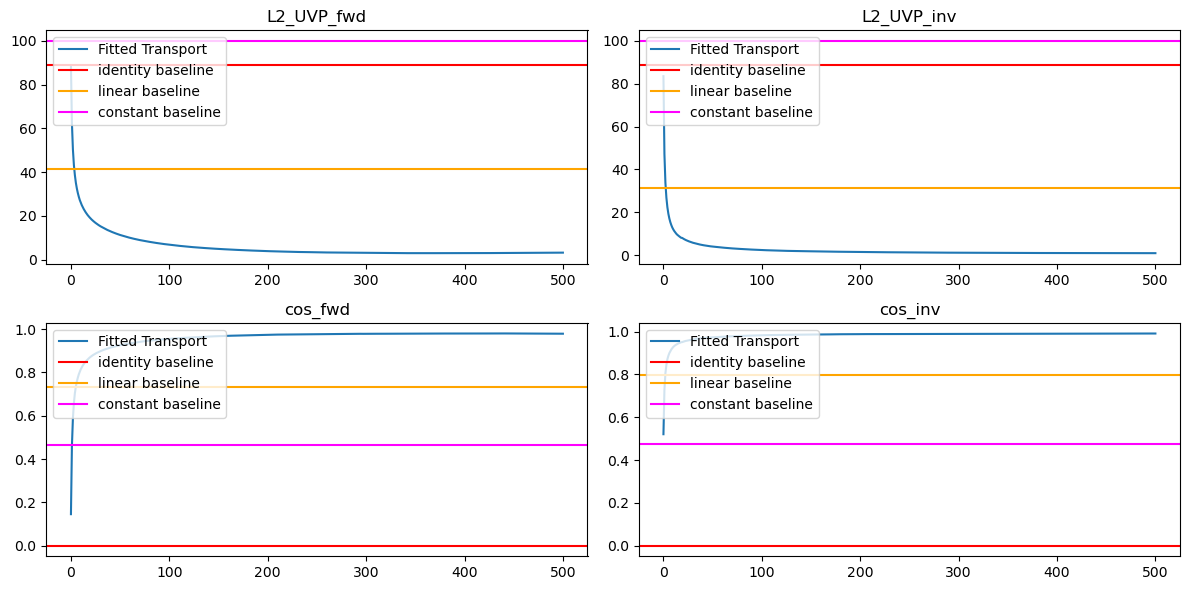

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50001/50001 [3:21:27<00:00,  4.14it/s]


In [9]:
for iteration in tqdm(range(MAX_ITER)):
    X = benchmark.input_sampler.sample(BATCH_SIZE); X.requires_grad_(True)
    Y = benchmark.output_sampler.sample(BATCH_SIZE); Y.requires_grad_(True)
    
    if not REVERSED:
        unfreeze(D); freeze(D_conj)
        # Negative Wasserstein distance
        Y_inv = D_conj.push(Y).detach()
        D_opt.zero_grad()  
        W_loss = (D(X) - D(Y_inv)).mean()

        # Non-backpropagated part
        with torch.no_grad():
            W_loss_nograd = (- (X ** 2).sum(dim=1) / 2).mean() +\
            ((Y_inv * Y).sum(dim=1) - (Y_inv ** 2).sum(dim=1) / 2 ).mean()

        W2_history.append(-W_loss.item() - W_loss_nograd.item())
        W_loss.backward(); D_opt.step();

        if CONVEX: D.convexify(); 

        unfreeze(D_conj); freeze(D)
        for inner_it in range(INNER_ITERS): 
            Y = benchmark.output_sampler.sample(BATCH_SIZE)
            Y.requires_grad_(True)

            D_conj_opt.zero_grad()
            Y_push = D_conj.push(Y)
            conj_loss = (D(Y_push) - (Y_push * Y).sum(dim=1, keepdims=True)).mean()
            conj_loss.backward()
            D_conj_opt.step();

            if CONVEX: D_conj.convexify()   

    if REVERSED:
        unfreeze(D_conj); freeze(D)
        # Negative Wasserstein distance
        X_inv = D.push(X).detach()
        D_conj_opt.zero_grad()  
        W_loss = (D_conj(Y) - D_conj(X_inv)).mean()

        # Non-backpropagated part
        with torch.no_grad():
            W_loss_nograd = (- (Y ** 2).sum(dim=1) / 2).mean() +\
            ((X_inv * X).sum(dim=1) - (X_inv ** 2).sum(dim=1) / 2 ).mean()

        W2_history.append(-W_loss.item() - W_loss_nograd.item())
        W_loss.backward(); D_conj_opt.step();

        if CONVEX: D_conj.convexify(); 

        unfreeze(D); freeze(D_conj)
        for inner_it in range(INNER_ITERS): 
            X = benchmark.input_sampler.sample(BATCH_SIZE)
            X.requires_grad_(True)

            D_opt.zero_grad()
            X_push = D.push(X)
            conj_loss = (D_conj(X_push) - (X_push * X).sum(dim=1, keepdims=True)).mean()
            conj_loss.backward()
            D_opt.step();

            if CONVEX: D.convexify() 
    
    if iteration % 100 == 0:
        L2_UVP_fwd, cos_fwd, L2_UVP_inv, cos_inv = score_fitted_maps(benchmark, D, D_conj)        
        metrics['L2_UVP_fwd'].append(L2_UVP_fwd); metrics['cos_fwd'].append(cos_fwd)
        metrics['L2_UVP_inv'].append(L2_UVP_inv); metrics['cos_inv'].append(cos_inv)
        
        if L2_UVP_fwd < L2_UVP_fwd_min:
            torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'{DIM}-{METHOD}.pt'))
            L2_UVP_fwd_min = L2_UVP_fwd
    
        if L2_UVP_inv < L2_UVP_inv_min:
            torch.save(D_conj.state_dict(), os.path.join(OUTPUT_PATH, f'{DIM}-{METHOD}_conj.pt'))
            L2_UVP_inv_min = L2_UVP_inv
                    
    if iteration % 1000 == 0:
        clear_output(wait=True)
        print("Iteration", iteration)
        
        fig, axes = plot_benchmark_emb(benchmark, emb_X, emb_Y, D, D_conj)
        plt.show(fig); plt.close(fig)
        
        fig, axes = plot_W2(benchmark, W2_history)
        plt.show(fig); plt.close(fig)
        
        fig, axes = plot_benchmark_metrics(benchmark, metrics, baselines)
        plt.show(fig); plt.close(fig)

In [10]:
print(f'Logging Metrics Evolution to {OUTPUT_PATH}')
results = pd.DataFrame(metrics)
results.to_csv(os.path.join(OUTPUT_PATH, f'{DIM}-{METHOD}.csv'))
print('Done!')

Logging Metrics Evolution to ../logs/Mix3toMix10
Done!
